### Final Exam: Homework Assigmentment

The final exam evaluates feature importance and how it changes depending on the transfmation of the data.

Feature importance is evaluated  using MDI, MDA and SFI.

In [16]:
# Import packages
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl
from IPython.display import Image
from dotenv import load_dotenv


mpl.rcParams['figure.figsize'] = (16, 6)

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# load env variables
load_dotenv('../config.env')

# Import MlFinLab tools
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                         single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import get_orthogonal_features

from mlfinlab.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score
from mlfinlab.util.multiprocess import process_jobs
from mlfinlab.util.generate_dataset import generate_classification_dataset

In [17]:
# defining the function to generate the dataset

def make_test_data(n_features=40, n_informative=10, n_redundant=10, n_samples=1000):
    X, y = generate_classification_dataset(n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, n_samples=n_samples)

    # We add a time index to both our samples and labels
    dt_index = pd.DatetimeIndex(pd.date_range(periods=n_samples, freq="1min", end=datetime.today()))
    X.index = dt_index
    y.index = dt_index

    return X, y


In [18]:
# defining the function to produce feature importance statistics

def feature_importances(X, y, method, allow_masking_effects=False, n_splits=10):
    """
    Method to calculate MDI, MDA, and SFI feature importance.
    """

    max_features = None if allow_masking_effects else 1
    clf = DecisionTreeClassifier(criterion='entropy', max_features=max_features,
                                 class_weight='balanced', min_weight_fraction_leaf=0.0)

    clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.0,
                            max_samples=1.0, oob_score=True, n_jobs=-1)
    fit = clf.fit(X, y)
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=pd.Series(y.index, index=y.index))
    oos_score = ml_cross_val_score(clf, X, y, cv_gen=cv_gen,
                                   scoring=accuracy_score, require_proba=False).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, y, cv_gen, scoring=accuracy_score, require_proba=False)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, y, cv_gen, scoring=accuracy_score, require_proba=False)

    return imp, oob_score, oos_score

# defining the function to plot the feature importance statistics

def test_data_func(X, y, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    """
    Method to calculate MDI, MDA, and SFI feature importance with plotting.
    """

    for method in methods:
        feature_imp, oob_score, oos_score = feature_importances(X, y, method, allow_masking_effects)

        plot_feature_importance(feature_imp, oob_score=oob_score, oos_score=oos_score,
                                save_fig=True, output_path='../Data/images/{}_feat_imp{}.png'.format(method, run))

### 1.
1. Generate a dataset (X; y)
1. (b) Apply a PCA transformation on X, which we denote by _X .
1. (c) Compute MDI, MDA, and SFI feature importance on ( _X ; y), where the base estimator is RF.
1. (d) Do the three methods agree on what features are important? Why?

In [19]:
# generating the dataset (X, y)

X, y = make_test_data(n_features=12, n_informative=4, n_redundant=4, n_samples=300)

X.head()

,I_0,I_1,I_2,I_3,N_0,N_1,N_2,N_3,R_0,R_1,R_2,R_3
2025-05-12 08:16:09.348422,-1.461435,-3.259140,-0.873953,3.329074,0.088389,-0.177068,0.733894,0.867819,-1.461435,3.329074,-3.259140,-1.461435
2025-05-12 08:17:09.348422,-0.303242,-0.133859,-1.177818,0.726711,-0.150741,-1.154609,-1.614361,-1.453265,-0.303242,0.726711,-0.133859,-0.303242
2025-05-12 08:18:09.348422,-1.156336,0.802849,-1.394459,0.263851,-1.021484,0.737634,0.319999,1.092688,-1.156336,0.263851,0.802849,-1.156336
2025-05-12 08:19:09.348422,-1.820970,2.251769,-1.153326,-0.342610,-0.794358,0.733720,0.670218,0.501350,-1.820970,-0.342610,2.251769,-1.820970
2025-05-12 08:20:09.348422,-0.540018,-1.919059,-1.089877,1.681576,-0.456125,0.040553,0.922115,-1.720215,-0.540018,1.681576,-1.919059,-0.540018


In [20]:
y.head()

2025-05-12 08:16:09.348422    0
2025-05-12 08:17:09.348422    0
2025-05-12 08:18:09.348422    0
2025-05-12 08:19:09.348422    0
2025-05-12 08:20:09.348422    0
Freq: T, dtype: int64

In [21]:
# applying PCA transformation on X
X_pca = pd.DataFrame(get_orthogonal_features(X), index=X.index).add_prefix("PCA_")
X_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
2025-05-12 08:16:09.348422,-2.235860,-3.763902,-0.701775,1.241025,-0.151394,-0.990661,-0.088189,-0.848514
2025-05-12 08:17:09.348422,0.097339,-0.718047,1.715100,-0.872873,1.066259,-0.582397,-0.597617,0.914400
2025-05-12 08:18:09.348422,1.418845,-0.874766,-1.824041,-0.293595,-0.064174,-0.339565,-0.204219,0.990928
2025-05-12 08:19:09.348422,3.042638,-0.543448,-1.523155,-0.046793,-0.385346,-0.099890,-0.770337,1.429696
2025-05-12 08:20:09.348422,-1.333010,-1.868600,0.599389,-0.214792,-1.344618,-0.405342,-1.318990,-0.138189


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


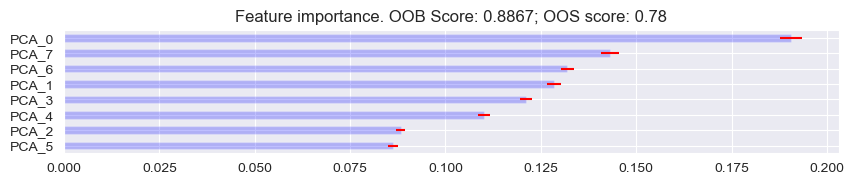

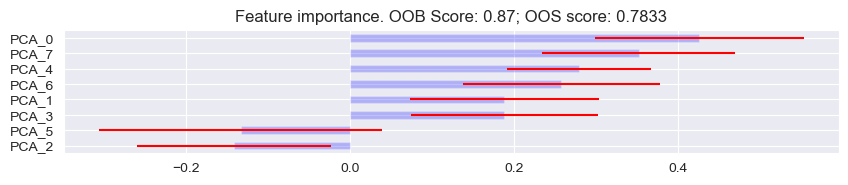

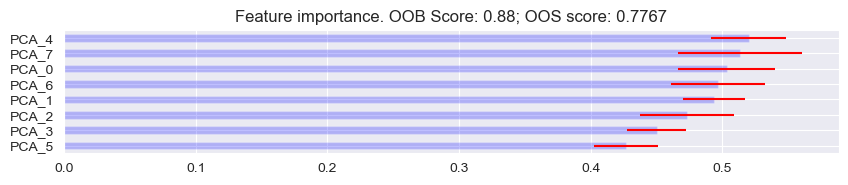

In [22]:
# computing MDI, MDA, and SFI feature importance on ( _X ; y), where the base estimator is RF
test_data_func(X_pca, y, '_8.1c')

### 2.

1. Compute MDI, MDA, and SFI feature importance on ( X; y), where the base estimator is RF.
2. Do the three methods agree on the important features? Why?

In [23]:
# generate a new dataset which is the feature union of the original dataset and the PCA dataset
X_joined = pd.concat([X, X_pca], axis=1)


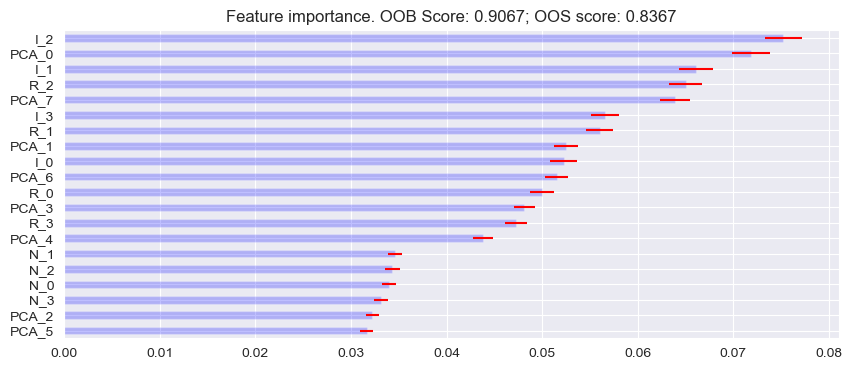

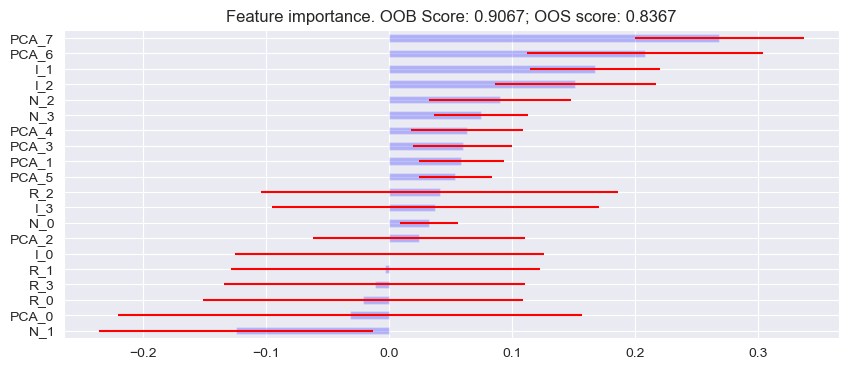

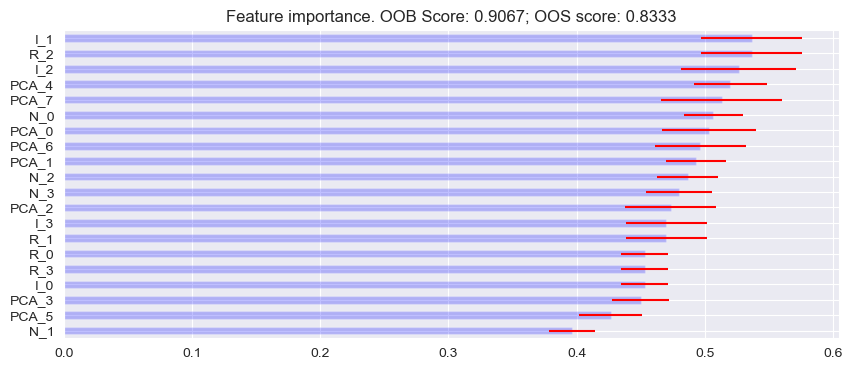

In [24]:
# computing MDI, MDA, and SFI feature importance of the joined dataset
test_data_func(X_joined, y, '_8.2a')

# 3.

Take the results from exercise 2 above.
1. (a) Drop the most important features according to each method, resulting in a features
matrix X___.
2. (b) Compute MDI, MDA, and SFI feature importance on (X___; y), where the base
estimator is RF.
3. (c) Do you appreciate signi cant changes in the rankings of important features, relative
to the results from exercise 2?

In [25]:
# creating a list of top 5 most important features across all three methods
top_5_features = [
    'I_2', 'PCA_0', 'I_1', 'R_2', 'PCA_7',
    'PCA_6', 'I_1', 'I_2', 'N_2', 'N_3',
    'PCA_4','N_0','PCA_1']

In [26]:
# droping the most important features according to each method
X_dropped = X_joined.drop(columns=top_5_features)

In [27]:
X_dropped.head()

,I_0,I_3,N_1,R_0,R_1,R_3,PCA_2,PCA_3,PCA_5
2025-05-12 08:16:09.348422,-1.461435,3.329074,-0.177068,-1.461435,3.329074,-1.461435,-0.701775,1.241025,-0.990661
2025-05-12 08:17:09.348422,-0.303242,0.726711,-1.154609,-0.303242,0.726711,-0.303242,1.715100,-0.872873,-0.582397
2025-05-12 08:18:09.348422,-1.156336,0.263851,0.737634,-1.156336,0.263851,-1.156336,-1.824041,-0.293595,-0.339565
2025-05-12 08:19:09.348422,-1.820970,-0.342610,0.733720,-1.820970,-0.342610,-1.820970,-1.523155,-0.046793,-0.099890
2025-05-12 08:20:09.348422,-0.540018,1.681576,0.040553,-0.540018,1.681576,-0.540018,0.599389,-0.214792,-0.405342


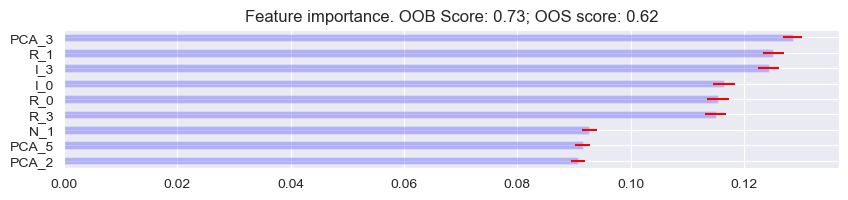

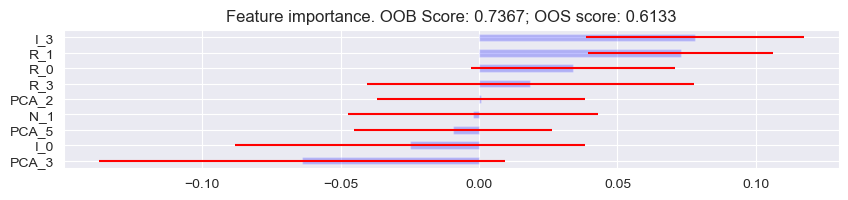

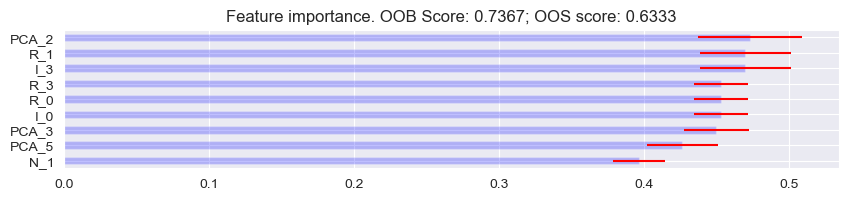

In [28]:
# computing MDI, MDA, and SFI feature importance on (X___; y), where the base estimator is RF
test_data_func(X_dropped, y, '_8.3a')